In [1]:
!pip install -U -q PyDrive

In [2]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [3]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.metrics import silhouette_score
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering

In [5]:
!mkdir data

In [6]:
file_id = '1SC23SPYYC-vYWM--4DJp-UsaD0OxQU7W'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('data/regression.csv')

In [7]:
df = pd.read_csv('data/regression.csv', index_col=0).drop('pageviews', axis=1)

In [8]:
df.head()

,num_commits,avg(diff)
uid,,
user_1,62,-64.4
user_2,46,-137.2
user_3,18,-105.4
user_4,40,-175.6
user_6,15,-62.6


In [9]:
kmeans = KMeans(n_clusters=3, random_state=21)

In [10]:
kmeans.fit(df)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=21, tol=0.0001, verbose=0)

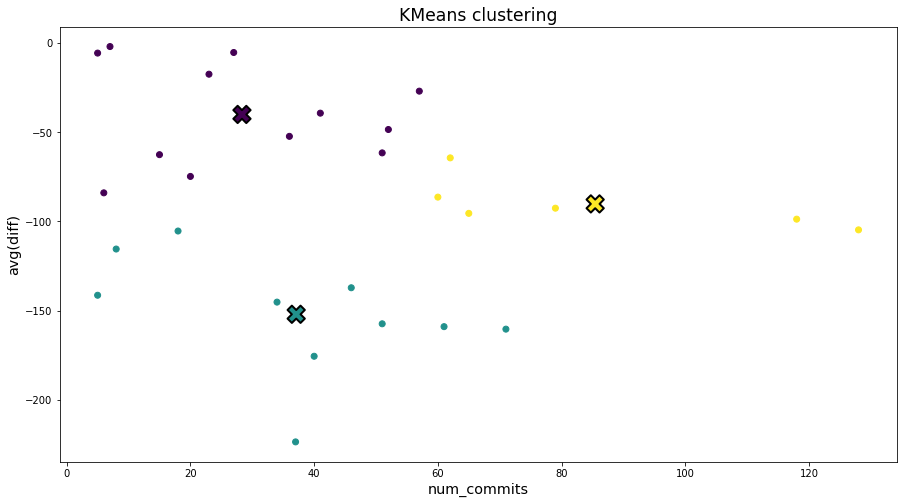

In [11]:
fig, ax = plt.subplots(figsize=(15, 8))
ax.scatter(df['num_commits'], df['avg(diff)'], c=kmeans.labels_)
ax.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300,
           c=np.arange(kmeans.n_clusters), marker='X', linewidths=2,
           edgecolors='k')
ax.set_xlabel('num_commits', fontsize='x-large')
ax.set_ylabel('avg(diff)', fontsize='x-large')
ax.set_title('KMeans clustering', fontsize='xx-large')
plt.show()

In [12]:
silhouette_score(df, kmeans.labels_)

0.4390170957153296

In [13]:
dbscan = DBSCAN(eps=20, min_samples=2)

In [14]:
dbscan.fit(df)

DBSCAN(algorithm='auto', eps=20, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=2, n_jobs=None, p=None)

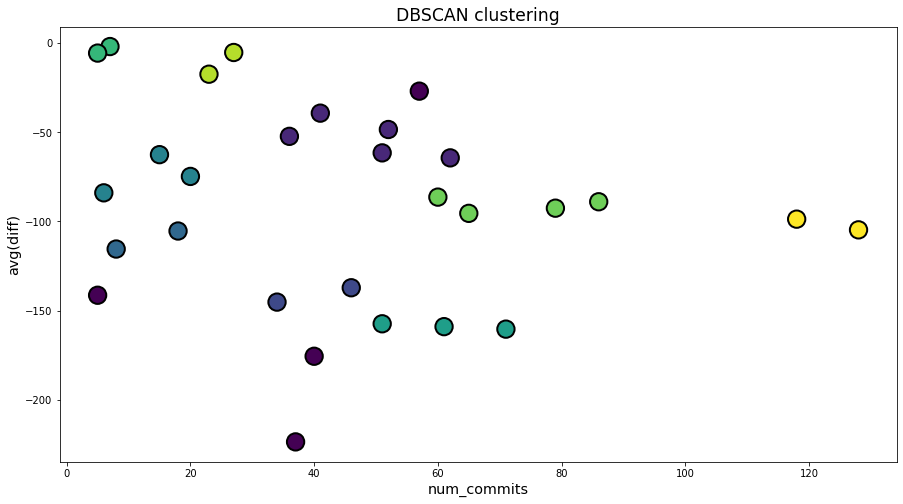

In [15]:
fig, ax = plt.subplots(figsize=(15, 8))
ax.scatter(df['num_commits'], df['avg(diff)'], s=300, c=dbscan.labels_,
           linewidths=2, edgecolors='k')
ax.set_xlabel('num_commits', fontsize='x-large')
ax.set_ylabel('avg(diff)', fontsize='x-large')
ax.set_title('DBSCAN clustering', fontsize='xx-large')
plt.show()

In [16]:
silhouette_score(df, dbscan.labels_)

0.38339641455696605

In [17]:
ward = AgglomerativeClustering(n_clusters=5)

In [18]:
ward.fit(df)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='ward', memory=None, n_clusters=5)

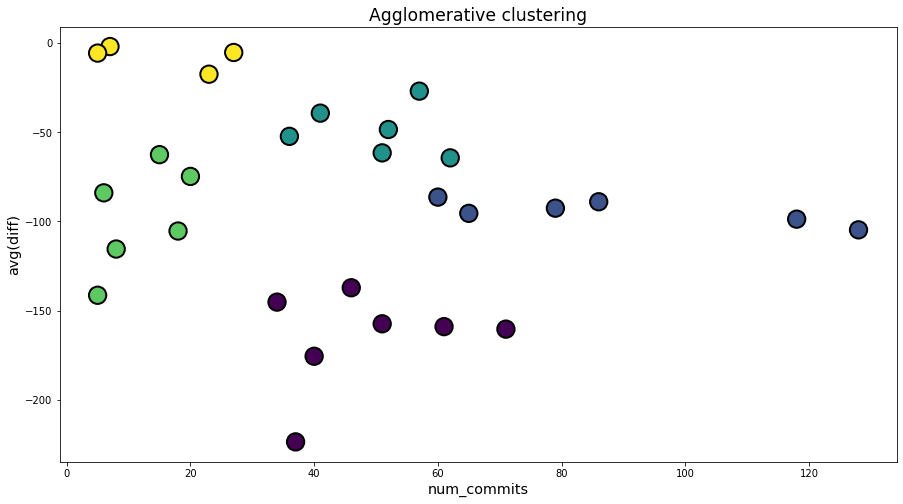

In [19]:
fig, ax = plt.subplots(figsize=(15, 8))
ax.scatter(df['num_commits'], df['avg(diff)'], s=300, c=ward.labels_,
           linewidths=2, edgecolors='k')
ax.set_xlabel('num_commits', fontsize='x-large')
ax.set_ylabel('avg(diff)', fontsize='x-large')
ax.set_title('Agglomerative clustering', fontsize='xx-large')
plt.show()

In [20]:
silhouette_score(df, ward.labels_)

0.4638301519938145

In [21]:
def plot_dendrogram(model, **kwargs):
    children = model.children_
    distance = np.arange(children.shape[0])
    no_of_observations = np.arange(2, children.shape[0]+2)
    linkage_matrix = np.column_stack([children, distance, no_of_observations]
                                     ).astype(float)
    dendrogram(linkage_matrix, **kwargs)

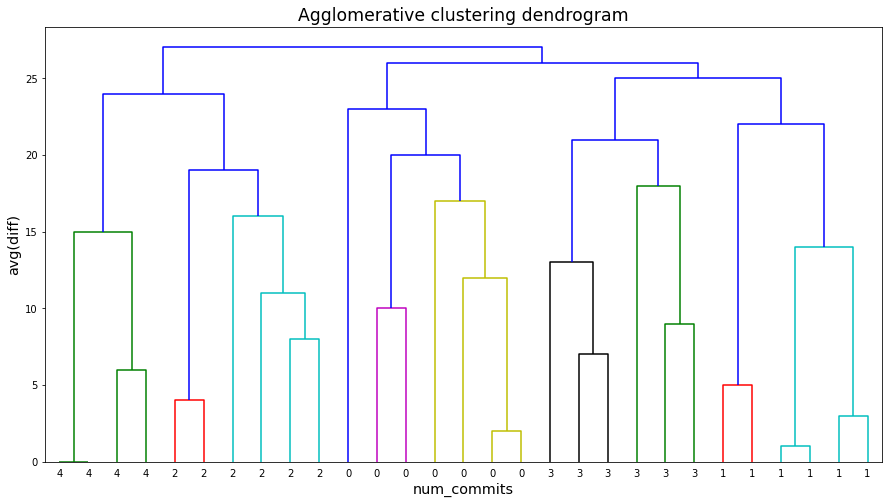

In [22]:
plt.rcParams['figure.figsize'] = (15, 8)
plot_dendrogram(ward, labels=ward.labels_)
plt.xticks(rotation='horizontal')
plt.xlabel('num_commits', fontsize='x-large')
plt.ylabel('avg(diff)', fontsize='x-large')
plt.title('Agglomerative clustering dendrogram', fontsize='xx-large')
plt.show()

In [23]:
def scorer(estimator, X):
    estimator.fit(X)
    return silhouette_score(X, estimator.labels_)

In [35]:
def plot_clustering(estimator, param, values):
    param_grid = {param: values}
    cv = GridSearchCV(estimator, param_grid, scoring=scorer, n_jobs=-1, cv=3)
    cv.fit(df)
    print(f'Best {param} value: {cv.best_params_[param]}')
    fig, axes = plt.subplots(1, 2, figsize=(15, 8), tight_layout=True)
    axes[0].plot(values, cv.cv_results_['mean_test_score'])
    axes[0].set_xlabel(param)
    axes[0].set_ylabel('silhouette_score')
    axes[0].set_title('Silhouette plot')
    axes[1].scatter(df['num_commits'], df['avg(diff)'], s=300,
                    c=cv.best_estimator_.labels_, linewidths=2, edgecolors='k')
    axes[1].set_xlabel('num_commits')
    axes[1].set_ylabel('avg(diff)')
    axes[1].set_title('Clusters')
    plt.show()

In [36]:
kmeans = KMeans(random_state=21)

Best n_clusters value: 4


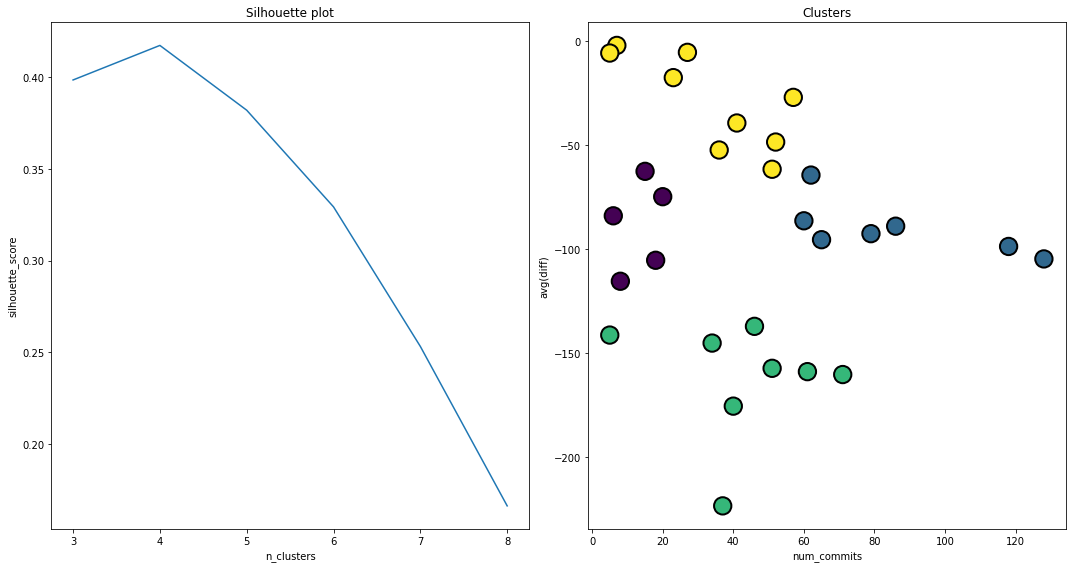

In [37]:
plot_clustering(kmeans, 'n_clusters', np.arange(3, 9))

In [49]:
dbscan = DBSCAN(eps=20)

Best min_samples value: 2


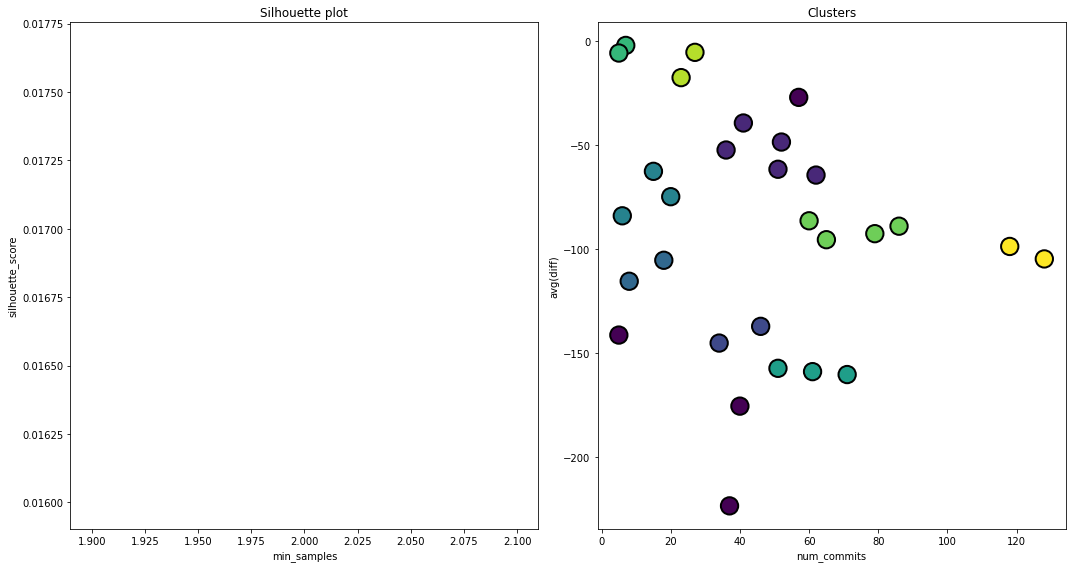

In [53]:
plot_clustering(dbscan, 'min_samples', np.arange(2, 3))

In [58]:
ward = AgglomerativeClustering()

Best n_clusters value: 4


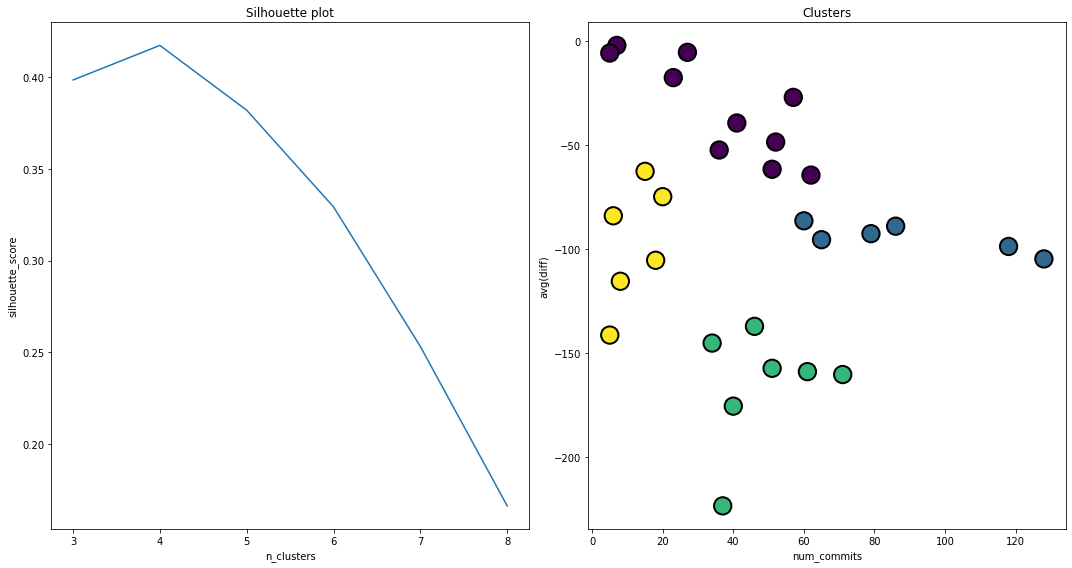

In [59]:
plot_clustering(ward, 'n_clusters', np.arange(3, 9))